This notebook requires v0.1

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm.notebook import tqdm
from pathlib import Path
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.utils import shuffle

import tensorflow as tf

from importlib import reload
import sentinel_utils
import keras_model_creator
import plot_utils

from data_generator import DataGenerator

pd.options.mode.copy_on_write = True

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
reload(sentinel_utils)
utils = sentinel_utils.SentinelUtils(min_occurrences=20000)

selected_sentinel = ['B3', 'B6', 'B8', 'B11']

In [3]:
model_parent_dir = Path('models', 'soilgrid_elevation')

loss = 'binary_crossentropy'
batch_size = 64
base_filters = 32
shards_dir = Path.home().joinpath('sentinel_data', 'shards')

seasons = ['06']
selected_classes = utils.get_processed_labels()
data_summary = utils.get_data_summary(
    shards_dir, seasons, selected_classes)

fixed_params = dict(
    shards_dir=shards_dir,
    seasons=seasons,
    selected_classes=selected_classes,
    loss=loss,
    data_summary=data_summary,
    batch_size=batch_size,
    base_filters=base_filters,
    dropout=0.2,
    epochs=10,
    overwrite=False,
    verbose=1,
    print_log=False
)

In [5]:
reload(keras_model_creator)

band_groups = dict(
    sentinel=selected_sentinel,
    soilgrids=utils.soilgrids_bands,
    elevation=utils.elevation_band,
)
group_combinations = list(itertools.chain.from_iterable(
    itertools.combinations(band_groups.keys(), r) for r in range(1, len(band_groups)+1)
))
for comb in tqdm(list(group_combinations)[:1]):
    band_indices = []
    for group_name in comb:
        band_indices += [utils.all_bands.index(b) for b in band_groups[group_name]]

    model_dir = model_parent_dir.joinpath(
        f'{loss}-{len(selected_classes.index)}'
        f'-{selected_classes.shape[1]}-{len(band_indices)}'
        f'-{"_".join(seasons)}-{batch_size}-{base_filters}'
        f'-{"_".join(comb)}'
    )

    model_dir.mkdir(parents=True, exist_ok=True)
    
    changing_params = dict(
        model_dir=model_dir,
        band_indices=band_indices,
    )
    params = fixed_params | changing_params
    keras_model_creator.KerasModelCreator(**params).run()


  0%|          | 0/1 [00:00<?, ?it/s]

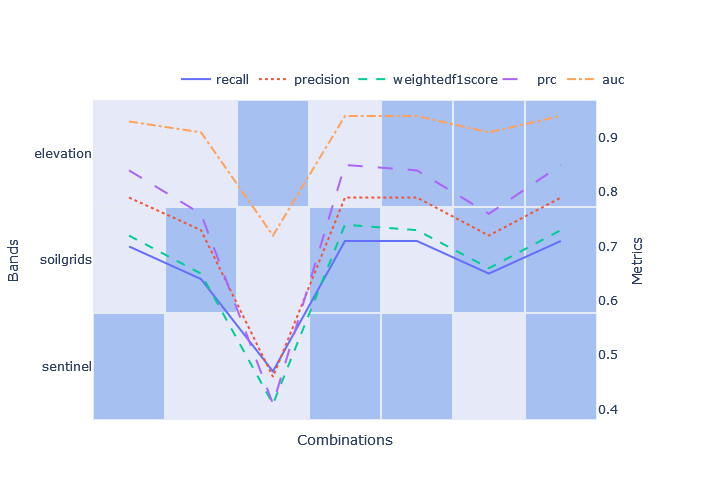

In [9]:
reload(plot_utils)

best_metric = 'val_weightedf1score'
best_rows = []

for comb in list(group_combinations):
    model_dirs = list(model_parent_dir.glob(f'*-{"_".join(comb)}'))

    for model_dir in model_dirs:
        df = pd.read_csv(model_dir.joinpath('model.log'))
        best = df[df[best_metric] == df[best_metric].max()]
        
        best[list(band_groups.keys())] = [int(c in comb) for c in band_groups.keys()]
        best_rows.append(best)
        
best_df = pd.concat(best_rows).round(2).reset_index(drop=True)

fig = plot_utils.PlotUtils().line_heatmap(
    best_df, list(band_groups.keys())
)

figure_dir = Path('report', 'figures', 'figures_analysis')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir.joinpath('soil_elevation_analysis.pdf'))
fig

In [ ]:
# for eval_year in [2017, 2020, 2021, 2022, 2023]:
    # eval_generator = DataGenerator(
        # utils.selected_classes.index, shuffle=False, year=eval_year, **params)
#     preds_path = model_dir.joinpath(f"preds_{params['year']}.npy")
#     if preds_path.is_file():
#         y_pred = np.load(preds_path)
#     else:
#         y_pred = model.predict(x=eval_generator, verbose=1)
#         np.save(preds_path, y_pred)

#     y_true = utils.selected_classes.iloc[:y_pred.shape[0]].to_numpy()
#     cm = confusion_matrix(y_true.flatten(), (y_pred > 0.5).flatten().astype(int))
#     plot = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
#     display(plot)

Visualise the confusion matrix for each class.

In [ ]:
# import matplotlib.pyplot as plt

# class_names = utils.selected_classes.columns

# f, axes = plt.subplots(4, 2, figsize=(25, 30))
# axes = axes.ravel()
# for label in range(y_true.shape[1]):
#     cm = confusion_matrix(y_true[..., label].astype(int), (y_pred[..., label] > 0.5).astype(int))
#     disp = ConfusionMatrixDisplay(cm)
#     disp.plot(ax=axes[label], values_format='.4g')
#     disp.ax_.set_title(f'{class_names[label]}')
#     if label < 25:
#         disp.ax_.set_xlabel('')
#     if label % 5 != 0:
#         disp.ax_.set_ylabel('')
#     disp.im_.colorbar.remove()

# plt.subplots_adjust(wspace=0.2, hspace=0.001)
# f.colorbar(disp.im_, ax=axes)
# plt.show()


In [ ]:
# import tensorflow
# tensorflow.keras.utils.plot_model(model, show_shapes=True)
# model.summary()

Visualise the model.

In [ ]:
# import tensorflow
# tensorflow.keras.utils.plot_model(
#     model, to_file=model_dir.joinpath('model.png'),
#     show_shapes=True, show_layer_activations=True,
# )

Correlate the model with climate variables (to move?)

In [ ]:
# import plotly.express as px

# class_names = utils.selected_classes.columns
# indices = utils.selected_classes.index

# preds_path = model_dir.joinpath(f'preds_2020.npy')
# y_prev = np.load(preds_path)

# weather_prev = pd.read_csv(Path('weather_data', 'era5_2020.csv'))
# eval_years = [2021, 2022, 2023]
# corrs = []

# for eval_year in eval_years:
#     preds_path = model_dir.joinpath(f'preds_{eval_year}.npy')
#     y_pred = np.load(preds_path)
#     y_diff = pd.DataFrame(y_pred - y_prev, columns=class_names)
    
#     weather = pd.read_csv(Path('weather_data', f'era5_{eval_year}.csv'))
#     weather_diff = ((weather - weather_prev)
#                     .loc[indices]
#                     .iloc[:y_pred.shape[0]]
#                     .iloc[y_diff.index])
    
#     corr = y_diff.join(weather_diff).corr(method='pearson').round(2)
#     corrs.append(corr)

#     y_prev = y_pred
#     weather_prev = weather

# fig = px.imshow(
#     np.array(corrs),
#     animation_frame=0,
#     labels=dict(color="Corr coef"),
#     x=corrs[0].index,
#     y=corrs[0].columns,
#     title='Annual correlation heatmap',
#     text_auto=True, aspect='auto', zmin=0, height=500
# )
# fig.layout.sliders[0]['currentvalue']['prefix'] = ''
# for year, step in zip(eval_years, fig.layout.sliders[0].steps):
#     step.label = str(year)

# fig